In [1]:
# Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Compsci 361 Assignment 3

## Task 1: Exploratory data analytics on text data


### a) 

In [2]:
data_X = pd.read_csv("train.csv")
data_y = pd.read_csv("test.csv")
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer()
tfid.fit(data_X["Text"])

tfidDF = tfid.transform(data_X["Text"])

#number of articles and features
num_articles = tfidDF.shape[0]
num_features = tfidDF.shape[1]

print(f"Number of articles: {num_articles}")
print(f"Number of extracted features: {num_features}")

#5 example articles
fivearticles = data_X["Text"].head(5)
features = tfidDF[:5].toarray()
feature_names = tfid.get_feature_names_out()

example_df = pd.DataFrame(features, columns=feature_names, index=fivearticles)

print(example_df.head())

Number of articles: 428
Number of extracted features: 13518
                                                     00       000  000th  \
Text                                                                       
lifestyle governs mobile choice faster better f...  0.0  0.020115    0.0   
french honour director parker british film dire...  0.0  0.000000    0.0   
fockers fuel festive film chart comedy meet foc...  0.0  0.000000    0.0   
housewives lift channel 4 ratings debut us tele...  0.0  0.000000    0.0   
u2 desire number one u2 three prestigious gramm...  0.0  0.000000    0.0   

                                                    001st  0051  007  0100  \
Text                                                                         
lifestyle governs mobile choice faster better f...    0.0   0.0  0.0   0.0   
french honour director parker british film dire...    0.0   0.0  0.0   0.0   
fockers fuel festive film chart comedy meet foc...    0.0   0.0  0.0   0.0   
housewives lift c

In [3]:
data_X["Category"].unique()

array(['tech', 'entertainment'], dtype=object)

For these articles, we peformed vectorisation using inverse document frequency as a way of tokenising the texts. From this, we observed 13518 unique words becoming our features from 428 articles.

### b)


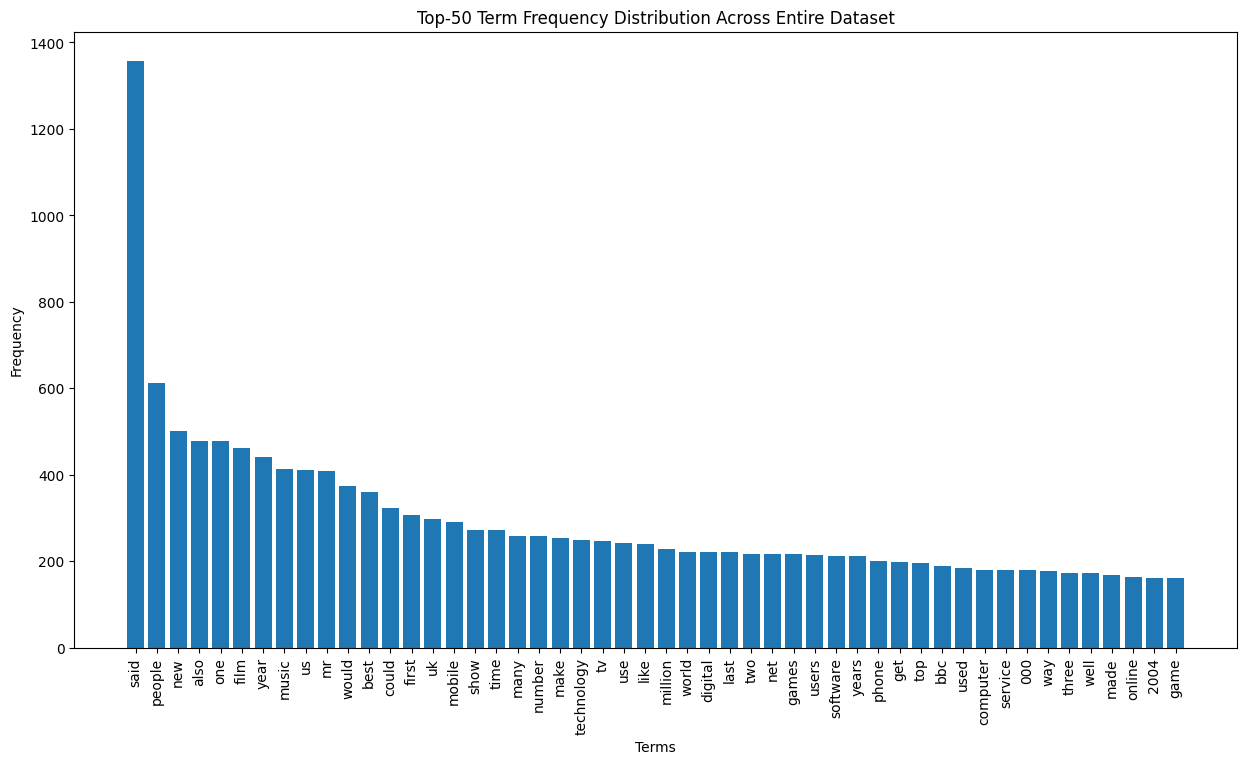

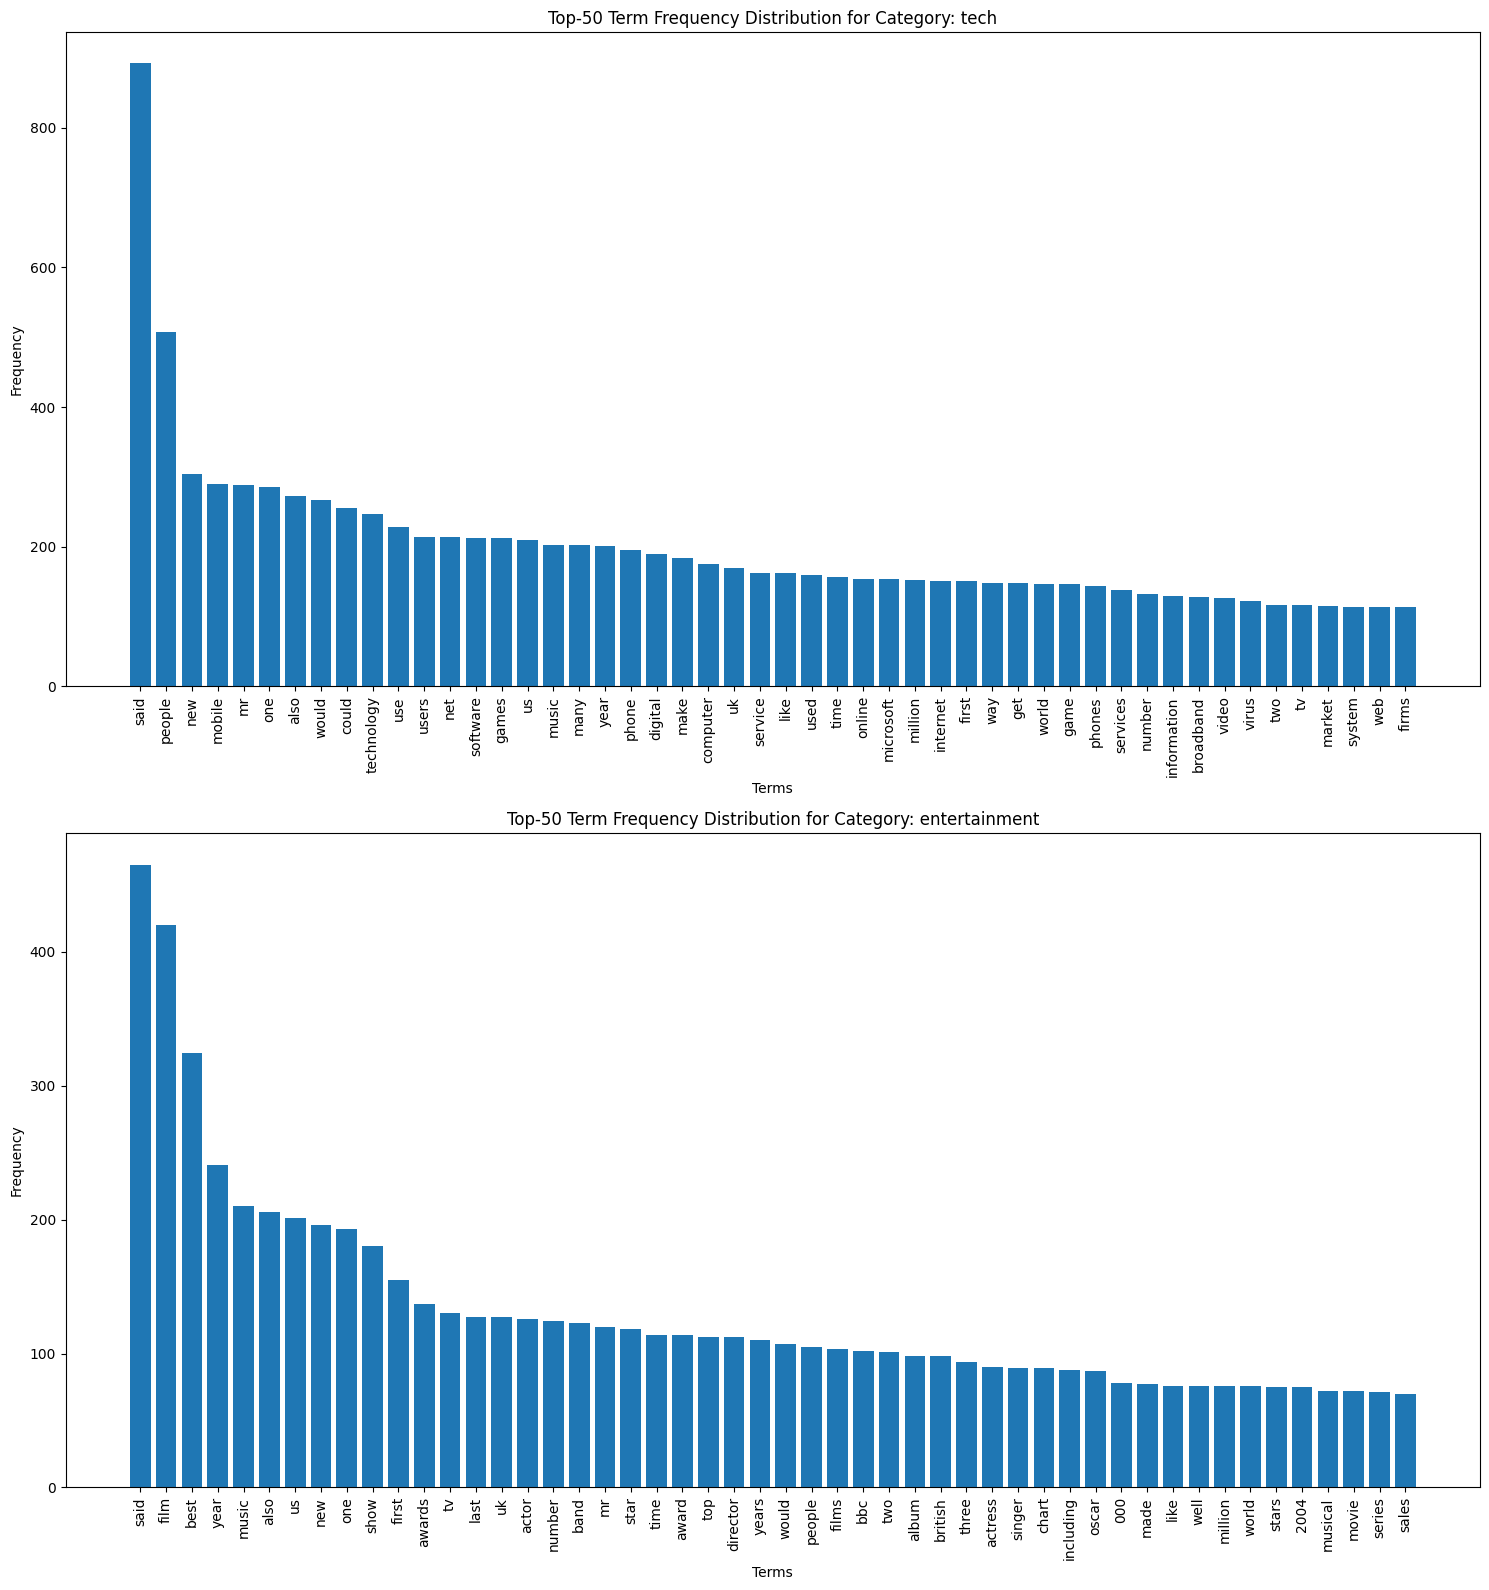

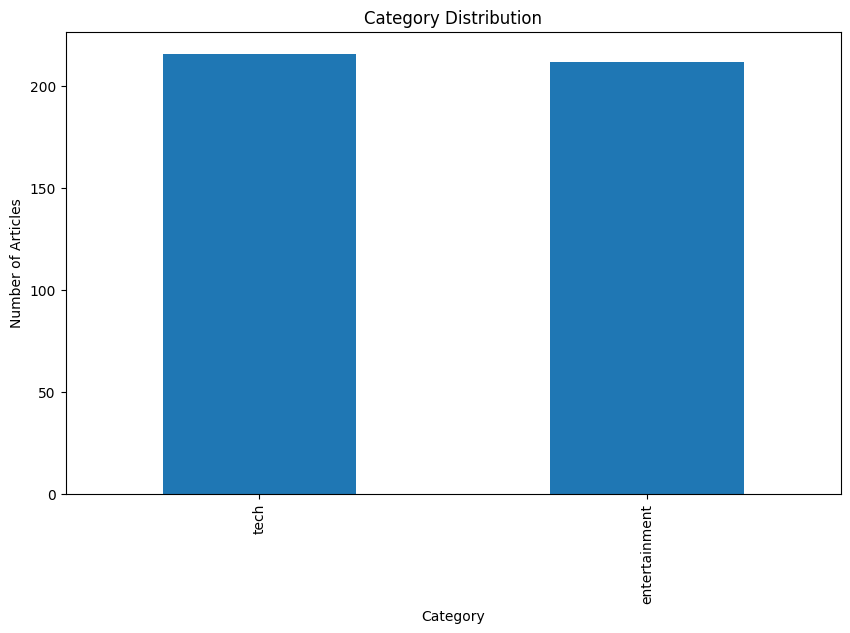

In [4]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

word_matrix = vectorizer.fit_transform(data_X["Text"])
word_hz = word_matrix.sum(axis=0).A1
terms = vectorizer.get_feature_names_out()

term_freq_df = pd.DataFrame({'term': terms, 'frequency': word_hz})
term_freq_df = term_freq_df.sort_values(by='frequency', ascending=False)

#plot 1
plt.figure(figsize=(15, 8))
top50 = term_freq_df.head(50)
plt.bar(top50['term'], top50['frequency'])
plt.xticks(rotation=90)
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.title('Top-50 Term Frequency Distribution Across Entire Dataset')
plt.show()

categories = data_X['Category'].unique()
term_hz = {}

for category in categories:
    category_texts = data_X[data_X['Category'] == category]['Text']
    category_word_matrix = vectorizer.transform(category_texts)
    category_word_hz = category_word_matrix.sum(axis=0).A1
    term_hz[category] = category_word_hz

#plot 2&3
fig, axes = plt.subplots(len(categories), 1, figsize=(15, 8 * len(categories)))

for i, category in enumerate(categories):
    term_freqDF = pd.DataFrame({'term': terms, 'frequency': term_hz[category]})
    term_freqDF = term_freqDF.sort_values(by='frequency', ascending=False)
    top50_terms = term_freqDF.head(50)
    
    axes[i].bar(top50_terms['term'], top50_terms['frequency'])
    axes[i].set_xticks(range(len(top50_terms['term'])))
    axes[i].set_xticklabels(top50_terms['term'], rotation=90)
    axes[i].set_xlabel('Terms')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Top-50 Term Frequency Distribution for Category: {category}')

plt.tight_layout()
plt.show()

#plot 4
plt.figure(figsize=(10, 6))
category_distribution = data_X['Category'].value_counts()
category_distribution.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.title('Category Distribution')
plt.show()

From looking at the above plots, we notice "said' was mentioned the most frequently across all articles, surpassing the closest frequent word by over two times. The remaining top term frequencies seems quite consistent ranging from 600 down to 200. We also see "said" is most frequent in the category tech compared to entertainment. Overall, the data seems fairly balanced with similar number of articles for each category. 

## Task 2: Classification Models Learning

In [5]:
#Vectorizing after data split
X_train, X_test, y_train, y_test = train_test_split(data_X["Text"], data_X["Category"], test_size=0.2,random_state=42)

#Tfid Vectorizer
X_train_tfid = tfid.fit_transform(X_train)
X_test_tfid = tfid.transform(X_test)

#Count Vectorizer
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)


Helper functions

In [6]:
def plot_graph_pca(X, y):
    std_scaler = StandardScaler(with_mean=False)
    scaled_X = std_scaler.fit_transform(X)
    pca = PCA(n_components = 2)
    components = pca.fit_transform(scaled_X)
    plt.scatter(components[:,0], components[:,1], c = y)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

### a) Naive Bayes

In [7]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()

model.fit(X_train_count, y_train)
pred = model.predict(X_test_count)

print('Gaussian Naive Bayes')
print('Accuracy:', accuracy_score(y_test, pred))
print('Classification Report:')
print(classification_report(y_test, pred))


Gaussian Naive Bayes
Accuracy: 0.9767441860465116
Classification Report:
               precision    recall  f1-score   support

entertainment       0.97      0.97      0.97        38
         tech       0.98      0.98      0.98        48

     accuracy                           0.98        86
    macro avg       0.98      0.98      0.98        86
 weighted avg       0.98      0.98      0.98        86



In [8]:
# finding the best 20 words:

log_probabilities = model.feature_log_prob_

words = vectorizer.get_feature_names_out()

change_log_probabilities = [abs(log_probabilities[0][i] - log_probabilities[1][i]) for i in range(len(log_probabilities[0]))]

value_order = np.argsort(change_log_probabilities)

best_20 = value_order[len(log_probabilities[0]) - 20:][::-1]

print(words[best_20])

['software' 'users' 'microsoft' 'singer' 'mobile' 'virus' 'oscar' 'band'
 'pc' 'firms' 'stars' 'broadband' 'rock' 'data' 'chart' 'album' 'actress'
 'nominations' 'gadget' 'festival']


### b) kNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

# Define parameters for GridSearchCV
knn_param_grid = {
    "n_neighbors": range(1, 50),
    "metric": ["euclidean", "manhattan", "minkowski", "cosine"]
}

# use cross validation to find optimal parameters k and distance metric
grid_search = GridSearchCV(knn, knn_param_grid, cv = 5)
grid_search.fit(X_train_count, y_train)
best_params = grid_search.best_params_
best_k = best_params["n_neighbors"]
best_metric = best_params["metric"]

print(f'Best parameters: k = {best_k}, metric = {best_metric}')

# train a knn classifier with the optimal parameters 
knn_best = KNeighborsClassifier(n_neighbors = best_k, metric = best_metric)
knn_best.fit(X_train_count, y_train)

y_pred_knn = knn_best.predict(X_test_count)

print("K-Nearest Neighbor:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))

Best parameters: k = 20, metric = cosine
K-Nearest Neighbor:
Accuracy: 0.9418604651162791
Classification Report:
               precision    recall  f1-score   support

entertainment       0.95      0.92      0.93        38
         tech       0.94      0.96      0.95        48

     accuracy                           0.94        86
    macro avg       0.94      0.94      0.94        86
 weighted avg       0.94      0.94      0.94        86



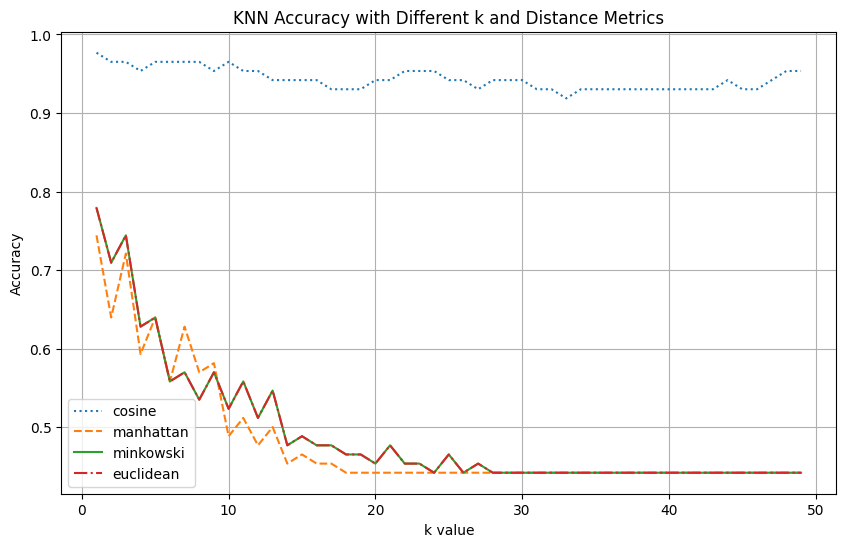

In [12]:
# graph of accuracy with different k and distance metrics

k_values = range(1, 50)
dist_metrics = ["cosine", "manhattan", "minkowski", "euclidean"]
accuracy_results = {}

for metric in dist_metrics:
    accuracy_results[metric] = []
    knn = KNeighborsClassifier(metric = metric)
    for k in k_values:
        knn.n_neighbors = k
        knn.fit(X_train_count, y_train)
        y_pred = knn.predict(X_test_count)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_results[metric].append(accuracy)

plt.figure(figsize = (10, 6))
line_styles = [":", "--", "-", "-."]
for metric, accuracy_val, style in zip(accuracy_results.keys(), accuracy_results.values(), line_styles):
    plt.plot(k_values, accuracy_val, label = metric, linestyle = style)
plt.xlabel("k value")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy with Different k and Distance Metrics")
plt.legend()
plt.grid(True)
plt.show()


When k is small, there is significant variability in the accuracy of the KNN model across all distance metrics. This is because a smaller k value means that the classifier is more sensitive to noise in the training data. As k increases, the accuracy tends to stabilize. The accuracies for manhattan, minkowski and euclidean distance metrics decrease gradually as k increases, converging to a stable but low value. Meanwhile, the accuracy of the cosine distance metric remains relatively high (> 0.9), suggesting that it is more robust to changes in k and can maintain high accuracy regardless of the value of k.

### c) SVM

In [18]:
# soft SVM
from sklearn.svm import SVC

# use cross validation to choose C
c_param = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(kernel = "linear"), c_param, cv = 5)
grid_search.fit(X_train_count, y_train)
best_c = grid_search.best_params_['C']
print(f'Best C parameter: {best_c}')

# train final model with best c
linear_svm = SVC(kernel = "linear", C = best_c)
linear_svm.fit(X_train_count, y_train)

y_pred_linear = linear_svm.predict(X_test_count)
print('Soft-Margin Linear SVM:')
print('Accuracy:', accuracy_score(y_test, y_pred_linear))
print('Classification Report:')
print(classification_report(y_test, y_pred_linear))

Best C parameter: 0.01
Soft-Margin Linear SVM:
Accuracy: 0.9883720930232558
Classification Report:
               precision    recall  f1-score   support

entertainment       0.97      1.00      0.99        38
         tech       1.00      0.98      0.99        48

     accuracy                           0.99        86
    macro avg       0.99      0.99      0.99        86
 weighted avg       0.99      0.99      0.99        86



#### Hard-Margin RBF with varying kernel width


In [19]:
gamma_param = {'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(SVC(kernel = "rbf"), gamma_param, cv = 5)
grid_search.fit(X_train_count, y_train)
best_gamma = grid_search.best_params_['gamma']
print(f'Best gamma parameter: {best_gamma}')

# train final model with best c
rbf_svm = SVC(kernel = "rbf", gamma = best_gamma)
rbf_svm.fit(X_train_count, y_train)

y_pred_rbf = rbf_svm.predict(X_test_count)
print('Hard-Margin RBF SVM:')
print('Accuracy:', accuracy_score(y_test, y_pred_rbf))
print('Classification Report:')
print(classification_report(y_test, y_pred_rbf))


Best gamma parameter: 0.001
Hard-Margin RBF SVM:
Accuracy: 0.9767441860465116
Classification Report:
               precision    recall  f1-score   support

entertainment       0.97      0.97      0.97        38
         tech       0.98      0.98      0.98        48

     accuracy                           0.98        86
    macro avg       0.98      0.98      0.98        86
 weighted avg       0.98      0.98      0.98        86



In [20]:
plot_graph_pca(X_train, y_train)

ValueError: could not convert string to float: 'net fingerprints combat attacks eighty large net service firms switched software spot stop net attacks automatically system creates digital fingerprints ongoing incidents sent every network affected firms involved smart sensing system believe help trace attacks back source data gathered passed police help build intelligence behind worm outbreaks denial service attacks firms signing sensing system include mci bt deutsche telekom energis ntt bell canada many others creation fingerprinting system brokered us firm arbor networks signatures attacks passed anyone suffering weight attack increasingly computer criminals using swarms remotely controlled computers carry denial service attacks websites launch worms relay spam around net seen attacks involving five ten gigabytes traffic said rob pollard sales director arbor networks behind fingerprinting system attacks size cause collateral damage cross internet get destination said attack spotted signature defined information passed back chain networks affected help every unwitting player tackle problem mr pollard said arbor charging service would pass fingerprint data every network affected want help net service firms communicate push attacks back around world source said mr pollard arbor network technology works building detailed history traffic network spots computers groups users regularly talk types traffic passes machines workgroups anomaly usual pattern spotted flagged network administrators take action traffic due net based attack kind type close analysis become useful net attacks increasingly launched using several hundred thousand different machines anyone looking traffic machine machine basis would unlikely spot part concerted attack attacks getting diffuse sophisticated said malcolm seagrave security expert energis last 12 months started getting noticeable criminals taking seen massive growth said although informal systems exist pass information attacks often commercial confidentiality got way sharing enough information properly combat attacks '

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

axi.scatter(X[y == 0, 0],
    X[y == 0, 1],
    s=50, c='lightblue',
    marker='s', edgecolor='black',
    label='class 1')
axi.scatter(X[y == 1, 0],
    X[y == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='class 2')

plot_svc_decision_function(model, axi)
axi.scatter(model.support_vectors_[:, 0],
    model.support_vectors_[:, 1],
    s=300, lw=1, facecolors='none');
axi.set_title('$\gamma$ = {0:.1f}'.format(gamma), size=16)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, gamma in zip(ax, [0.1, 100.0]):
    model = SVC(kernel='rbf', gamma=gamma, C=1.0).fit(X, y)
    
    

    axi.set_title('$\gamma$ = {0:.1f}'.format(gamma), size=16)

### d) Neural Network

## Task 3: Classification Quality Evaluation